In [4]:
import random
import matplotlib.pyplot as plt
import numpy as np
from trueskill import Rating, quality_1vs1, rate_1vs1
from utils import generate_population
%matplotlib inline

def scoreboard(population):
    for v in population.values():
        print(v.name, v.history)
        
def resign(user):
    if user.losing_streak == 0:
        if np.random.uniform() > 0.95:  # 95% chance of staying
            return True
    elif user.losing_streak == 1:
        if np.random.uniform() > 0.8:  # 80% chance of staying
            return True
    elif user.losing_streak == 2:
        if np.random.uniform() > 0.4:  # 40% chance of staying
            return True
    elif user.losing_streak == 3:
        if np.random.uniform() > 0.2:  # 20% chance of staying
            return True
    else:
        pass
    return False

def select_player(population):
    return population[random.choice(list(population.keys()))]

def win_probability(greater, lesser):
    # # https://github.com/sublee/trueskill/issues/1
    exp = (greater.mu - lesser.mu) / BETA
    n = 4. ** exp
    return n / (n + 1)


def update_retention(player, population):
    if resign(player):
        population.pop(player.name)
    return population

In [5]:
# algorithms.py

def find_losers(curr, population):
    # pick someone with the longest losing sterak
    candidates = sorted(population.values(), key=lambda x: x.losing_streak, reverse=True)
    candidates = list(map(lambda x: x.name, candidates))[:5]  # transform to a list of indices
    
    if curr.name in candidates:
        candidates.remove(curr.name)
        
    if len(candidates) == 0:
        candidates = list(population.keys())
        candidates.remove(curr.name)  # remove player from pool of potential players
    return candidates


def find_same(curr, population):
    candidates = []
    for k, v in population.items():

        # pick someone with the same losing streak, someone with the longest losing streak
        if (v.losing_streak == curr.losing_streak) and (v.name != curr.name):
            candidates.append(k)

    if len(candidates) == 0:
        candidates = list(population.keys())
        candidates.remove(curr.name)  # remove player from pool of potential players
        
    return candidates


def find_p1p2(p):
    """Select p1 and p2 for matchmaking.
    """
    p1 = select_player(p)

    pool = find_same(p1, p)
    # candidates = find_losers(p1, p)
    # pool = find_same_ranking(p1, p)
    p2 = p[random.choice(pool)]
    
    return p1, p2


def find_same_ranking(curr, population):        
    
    candidates = []
    for k, v in population.items():

        if (abs(v.rating.mu - curr.rating.mu) < BETA) and (v.name != curr.name):
            candidates.append(k)

    if len(candidates) == 0:
        candidates = list(population.keys())
        candidates.remove(curr.name)  # remove player from pool of potential players
    return candidates

In [7]:
BETA = 8.333

n_rollouts = 500
n_epochs = 100
retention = []
k = 100

for _ in range(n_rollouts):
    p = generate_population(k=k)
    
    for epoch in range(n_epochs):
        if len(p.keys()) == 0:
            raise ValueError("Empty population.")
        
        p1, p2 = find_p1p2(p)
        prob = win_probability(p1.rating, p2.rating)  # prob represents p1's p(win)
        
        if np.random.uniform() < prob:  # p1 wins
            p1.history.append(1)
            p2.history.append(0)
            p1.rating, p2.rating = rate_1vs1(p1.rating, p2.rating)
        else:
            p1.history.append(0)
            p2.history.append(1)
            p2.rating, p1.rating = rate_1vs1(p2.rating, p1.rating)

        # update retention
        p = update_retention(p1, p)
        p = update_retention(p2, p)
            
    retention.append(len(p.keys()))

<a list of 10 Patch objects>

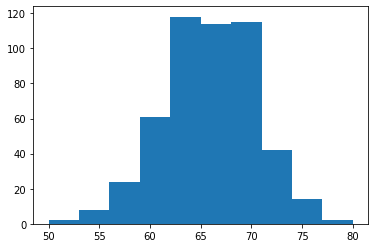

In [8]:
plt.hist(retention)[2]  # find same losing streak

In [ ]:
plt.hist(retention)[2]  # find same rankings

In [ ]:
scoreboard(p)